# Houses Price Prediction

En este proyecto, el objetivo es realizar una exploración de datos y modelar con regressión lineal para predecir los precios de un conjunto de propiedades. El presente Notebook en Jupyter busca realizar un preprocesamiento de los datos, limpieza y transformación para tener obtener un DataFrame listo para su modelado.

Adicionalmente, se visualizará el estado de los datos, la interrelación de las variables, sus estadísticos básicos y un proceso de normalización adecuado.

Se guardarán los modelos entrenados en un directorio para su uso sin necesidad de reentrenamiento al igual que la instancia de normalización de datos. 

Finalmente, en el directorio `data/` estará disponible tanto la data cruda y sin procesar como la data procesada. 

In [508]:
# Import Libraries
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import joblib
import os
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from scipy import stats
from scipy.stats import norm
import multiprocessing
tqdm.pandas()
plt.style.use('ggplot')
np.random.seed(2022)

## 1. Carga de Datos

Cargamos los datos crudos desde el directorio `data/` en un objeto DataFrame.

In [509]:
# Load Data 
data = pd.read_csv('../data/raw_data.csv', delimiter = ';')
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,13/10/2014,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,9/12/2014,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,25/2/2015,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,9/12/2014,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,18/2/2015,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


Vemos la forma del data frame

In [510]:
# Shape of DataFrame
print("N° Rows: {} \nN° Features: {}".format(data.shape[0], data.shape[1]))

N° Rows: 21597 
N° Features: 21


Vemos el tipo de datos y la cantidad de variables con el número de valores no nulos y el tipo de dato. 

In [511]:
# General Info of DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

Finalmente, visualizamos estadísticos básicos de los datos.

In [512]:
# Describe Features continuos
data.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,5.402966e+05
std,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950,3.673681e+05
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3.220000e+05
50%,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


## 2. Análisis Exploratorio de Datos (EDA)

La finalidad es examinar los datos previamente a la aplicación de cualquier técnica estadística. El objetivo es conseguir un entendimiento base de los datos y las relaciones existentes entre las variables.

### 2.1 Examen Gráfico

Realizamos un examen gráfico de las principales variables. En este caso, las vamos a comparar con la variable objetivo `sales`. Veamos como está el comportamiento.

#### Variables vs Objetivo

Se aprovecha la oportunidad de econtrar una ubicación mas intuitiva de cada propiedad. Utilizando la librería `Geopy`, podemos acceder a un servicio mediante API realizando peticiones mediante el ZipCode y saber en que ciudad se encuentra ubicado el inmueble.

Documentación: [Geopy](https://geopy.readthedocs.io/en/stable/)

In [513]:
def get_cityCounty(data):

    if (os.path.isfile('../data/zipcode_list.csv')):
        group_zipcode = pd.read_csv('../data/zipcode_list.csv')
        group_zipcode.set_index('zipcode', inplace = True)

        return group_zipcode

    else:

        # Group by for Zipcode
        group_zipcode = pd.DataFrame(data.groupby(['zipcode'])['zipcode'].count())\
                                    .rename({'zipcode':'count'}, axis = 1).reset_index()
        group_zipcode.sort_values(by = ['count'], ascending=False, inplace=True)

        # instance of Nominatim
        geoLoc = Nominatim(user_agent='geoLoc', timeout=10)
        # We care of number request to server with a RateLimiter.
        geoCode = RateLimiter(geoLoc.geocode, min_delay_seconds=0.0, max_retries = 2,
                                error_wait_seconds = 2.0, swallow_exceptions=True, 
                                return_value_on_exception=None)

        # apply discret function lambda in zipcode city
        group_zipcode['city'] = group_zipcode['zipcode']\
                                .progress_apply(lambda x: geoCode(query = {'country': 'United States of America', 'postalcode': x})\
                                .raw['display_name'].split(', ')[0])

        group_zipcode['county'] = group_zipcode['zipcode']\
                                .progress_apply(lambda x: geoCode(query = {'country': 'United States of America', 'postalcode': x})\
                                .raw['display_name'].split(', ')[1])


        # ZipCode as Index
        group_zipcode.set_index('zipcode', inplace=True)
        group_zipcode.to_csv('../data/zipcode_list.csv')

        return group_zipcode

In [514]:
# Get DataFrame with Zipcode for City and County
group_zipcode = get_cityCounty(data)

Migramos la data al DataFrame original creando un nuevo campo como `city`.

In [515]:
# Migrating values to Data
def search_city(data, zipcode:int) -> str:
    return data['city'][zipcode]

def search_county(data, zipcode:int) -> str:
    return data['county'][zipcode]

data['city'] = data['zipcode'].progress_apply(lambda x: search_city(group_zipcode, x))
data['county'] = data['zipcode'].progress_apply(lambda x: search_county(group_zipcode, x))

100%|██████████| 21597/21597 [00:00<00:00, 132125.40it/s]


In [516]:
# USD/sqft
df_plot = data.copy()
df_plot['sqft_usd'] = data['sqft_lot15']/data['price']
df_plot.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,city,county,sqft_usd
0,7129300520,13/10/2014,3,1.00,1180,5650,1.0,0,0,3,...,0,98178,47.5112,-122.257,1340,5650,221900,King County,Washington,0.025462
1,6414100192,9/12/2014,3,2.25,2570,7242,2.0,0,0,3,...,1991,98125,47.7210,-122.319,1690,7639,538000,Seattle,King County,0.014199
2,5631500400,25/2/2015,2,1.00,770,10000,1.0,0,0,3,...,0,98028,47.7379,-122.233,2720,8062,180000,Kenmore,King County,0.044789
3,2487200875,9/12/2014,4,3.00,1960,5000,1.0,0,0,5,...,0,98136,47.5208,-122.393,1360,5000,604000,Seattle,King County,0.008278
4,1954400510,18/2/2015,3,2.00,1680,8080,1.0,0,0,3,...,0,98074,47.6168,-122.045,1800,7503,510000,Sammamish,King County,0.014712


In [517]:
# Group by for city
group_city = pd.concat([df_plot.groupby(['city'])['price'].mean(), 
                        df_plot.groupby(['city'])['city'].count(),
                        df_plot.groupby(['city'])['sqft_lot15'].mean(),
                        df_plot.groupby(['city'])['sqft_usd'].mean()], axis=1)
group_city.rename({'city':'count'}, axis = 1, inplace = True)
group_city.reset_index(inplace = True)
# group_city.sort_values(by = 'count', ascending = False, inplace = True)

Ahora podemos visualizar el precio medio por ciudad. 

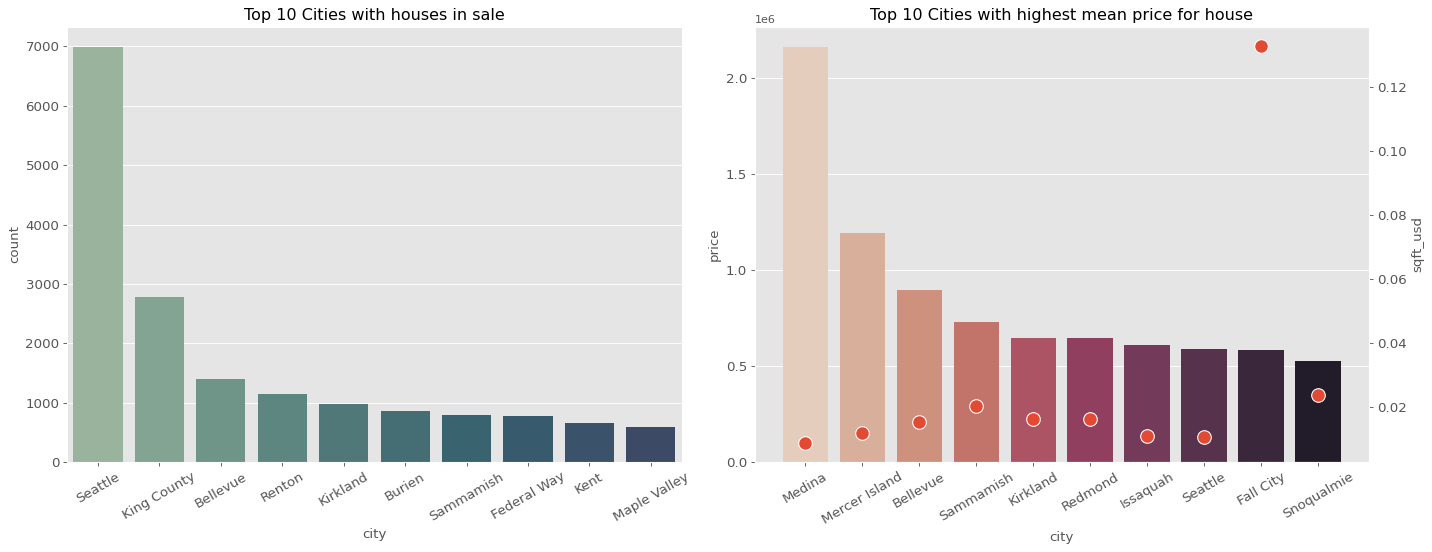

In [518]:
n_top = 10

# Create Canvas
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize = (18, 7), dpi = 80, tight_layout = True)

sns.barplot(x = 'city', y = 'count', data = group_city.sort_values(['count'], ascending = False).head(n_top), 
            palette = 'crest', saturation=.5, ax = ax1)

sns.barplot(x = 'city', y = 'price', data = group_city.sort_values(['price'], ascending = False).head(n_top), 
            palette = 'rocket_r', saturation=.5, ax = ax2)

ax2_2 = ax2.twinx()
sns.scatterplot(x = 'city', y = 'sqft_usd', s = 150, data = group_city.sort_values(['price'], ascending = False).head(n_top), 
                palette = 'viridis', marker = 'o', ax = ax2_2)

# Ticks params
ax1.tick_params(axis = 'x', labelrotation = 30, labelsize = 12)
ax1.tick_params(axis = 'y', labelsize = 12)
ax2.tick_params(axis = 'x', labelrotation = 30, labelsize = 12)
ax2.tick_params(axis = 'y', labelsize = 12)
ax2_2.tick_params(axis = 'y', labelsize = 12)

ax2_2.grid(False, axis = 'both')

ax1.set_title('Top 10 Cities with houses in sale')
ax2.set_title('Top 10 Cities with highest mean price for house')

plt.show()

Podemos observar que Seattle es claramente la ciudad del estado de Washington con mayor cantidad de inmuebles, a su vez su precio por pie cuadrado es el mas alto. Bellevue tiene precios más altos debido a que los inmuebles son mas grande en pie cuadrados. 

Análicemos el resto de las variables disponibles en el dataset. Podemos comparar variables estratégicas cómo:
* `grade`: Clasificación general de la vivienda (1 - 13)(pobre - excelente).
* `condition`: En que condiciones está la vivienda **1** desgastada → **5** excelente.
* `waterfront`: Si la vivienda tiene vista al mar (boolean).
* `floors`: Número de pisos. Existen valores decimales, es posible que se traten de pisos parciales.
* `view`: Cantidad de vista
* `bathrooms`: Cantidad de baños
* `betrooms`: Cantidad de habitaciones
* `year_build`: Año construido
* `yr_renovated`: Año de renovación
* `sqft_living`: Tamaño en pies cuadrados del living. Existe una medida actualizada en 2015 a raiz de renovaciones
* `sqft_lot`: Tamaño en pies cuadrados totales. Existe una medida actualizada en 2015 a raiz de renovaciones

Realizamos una regresion lineal simple para sqft_living como variable independiente `x` y price para la variable dependiente.

$
f(x) = \alpha + \sum_{j=1}^{n}\beta_{j}X_{i}
$

De forma generalizada:
 
$
f(x) = \alpha + \beta_{0}X
$

In [519]:
# Linear Regression of Scikit-Learn
lr = LinearRegression(fit_intercept = True)
X = np.array(df_plot['sqft_living']).reshape((len(df_plot),1))
y = np.array(df_plot['price']).reshape((len(df_plot),1))

# Training
lr.fit(X, y)

# Line test
x = np.linspace(0, X.max())
x = x.reshape((len(x),1))
y_predict = lr.predict(x)[:,0]

# coef and intercept point
beta = round(lr.coef_[0][0], 2)
alpha = round(lr.intercept_[0], 2)

ecu = "$f(x) = $" + str(alpha) + "$ + $" + str(beta) + "$X$"

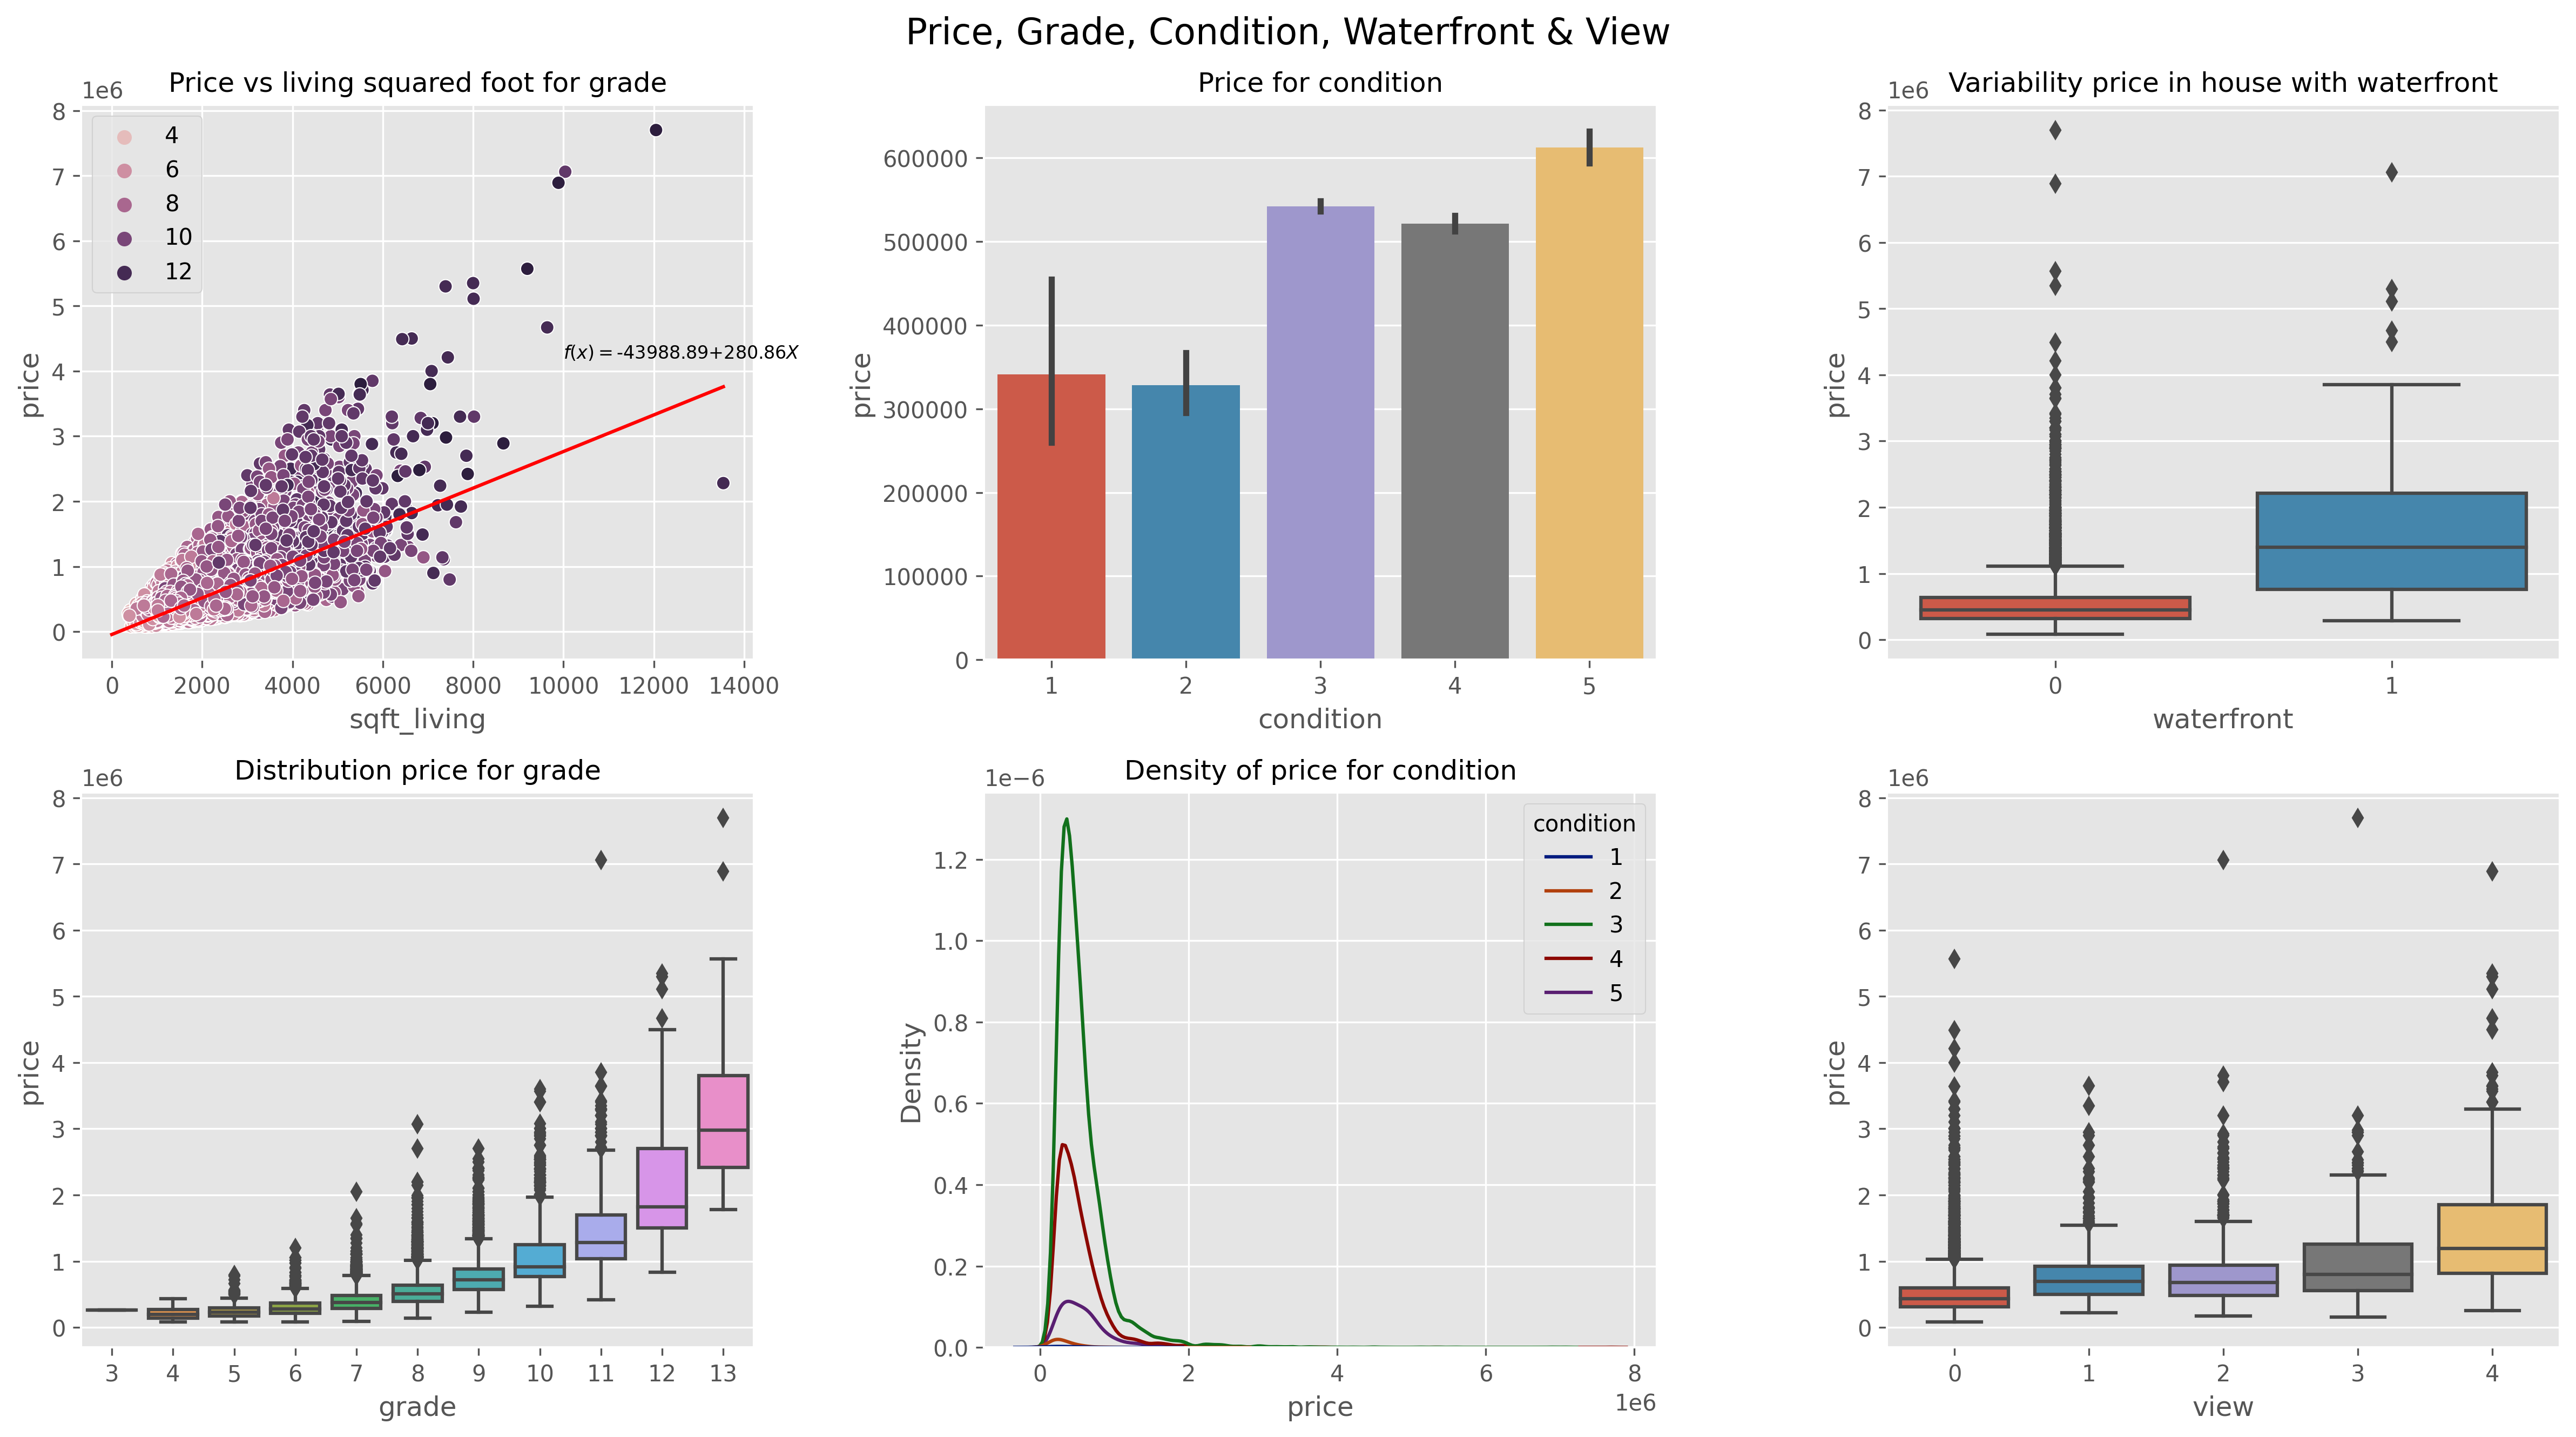

In [520]:
# Create Canvas
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 9), 
                                                        dpi = 300, tight_layout = True)

# Groupby data
condition_gb = pd.DataFrame(data.groupby('condition')['price'].mean()).reset_index()


# Plots
sns.scatterplot(x = 'sqft_living', hue = 'grade', y = 'price', data = df_plot, ax = ax1)
sns.lineplot(x = x[:,0], y = y_predict, color = 'red', ax = ax1)
ax1.text(x = 10000, y = 4.2e6, s = ecu, fontsize = 8)

sns.boxplot(x = 'grade', y = 'price', data = df_plot, ax = ax4)
sns.kdeplot(x='price', hue = 'condition', data = df_plot, cumulative=False, shade=False, palette='dark', ax=ax5)
sns.barplot(x = 'condition', y = 'price', data = df_plot, ax = ax2)
sns.boxplot(x = 'waterfront', y = 'price', data = df_plot, ax = ax3)
sns.boxplot(x = 'view', y = 'price', data = df_plot, ax = ax6)

ax1.set_title('Price vs living squared foot for grade', fontdict={'fontsize': 12})
ax2.set_title('Price for condition', fontdict={'fontsize': 12})
ax3.set_title('Variability price in house with waterfront', fontdict={'fontsize': 12})
ax4.set_title('Variability price in house with waterfront', fontdict={'fontsize': 12})
ax4.set_title('Distribution price for grade', fontdict={'fontsize': 12})
ax5.set_title('Density of price for condition', fontdict={'fontsize': 12})

fig.suptitle('Price, Grade, Condition, Waterfront & View', fontsize = 16)
plt.show()

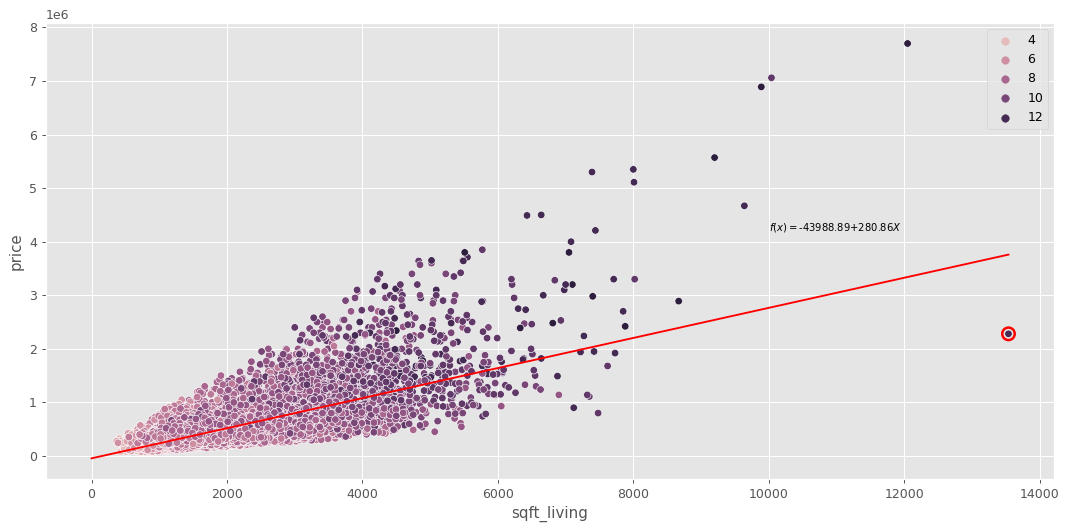

In [521]:
outlier = data[data['sqft_living'] > 13000]

# Create Canvas
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 6), dpi = 90, tight_layout = True)

# Plots
sns.scatterplot(x = 'sqft_living', hue = 'grade', y = 'price', data = df_plot, ax = ax)
ax.scatter(x = outlier['sqft_living'], y = outlier['price'], marker = 'o', s = 100, linewidths = 2, 
            color = 'red', facecolor = 'none', edgecolors = 'r')
sns.lineplot(x = x[:,0], y = y_predict, color = 'red', ax = ax)

ax.text(x = 10000, y = 4.2e6, s = ecu, fontsize = 8)


plt.show()

Exite un claro `outlier` en el gráfico de `price` vs `sqft_living`. Se trata de una vivienda que con un precio algo superior a los 200k de USD y superior a los 13k pies cuadrado. Se procede a eliminar dicha dato para evitar sesgo.

Podemos ver una relación lineal entre el `sqft_living` y el `price` del inmueble. Se pudo realizar una modelación del mismo con una regresión simple mediante `sickit-learn` y queda mostrado cuales son sus parametros $\alpha$ y $\beta$. A su vez es facilmente observable que mayor nivel en el grado de clasificación, el precio incrementa sustancialmente aunque su dispreción es más notoria en los tramos superiores de este ranking.

Existe una viariabilidad en el precio con respecto a la peor condición y menor en condiciones cercanas al excelente. Los precios son crecientes en aquellos inmuebles que se encuentran cerca al mar. En el dataset es evidente una mayor cantidad de datos en los tramos medios.

La vista tiene influencia sobre el precio, pero no parece ser significativa.

In [522]:
# Drop data that is outlier
data.drop(outlier.index.to_list(), axis = 0, inplace = True)

Veamos los datos con respecto a las habitaciones, baños y el numero de pisos.

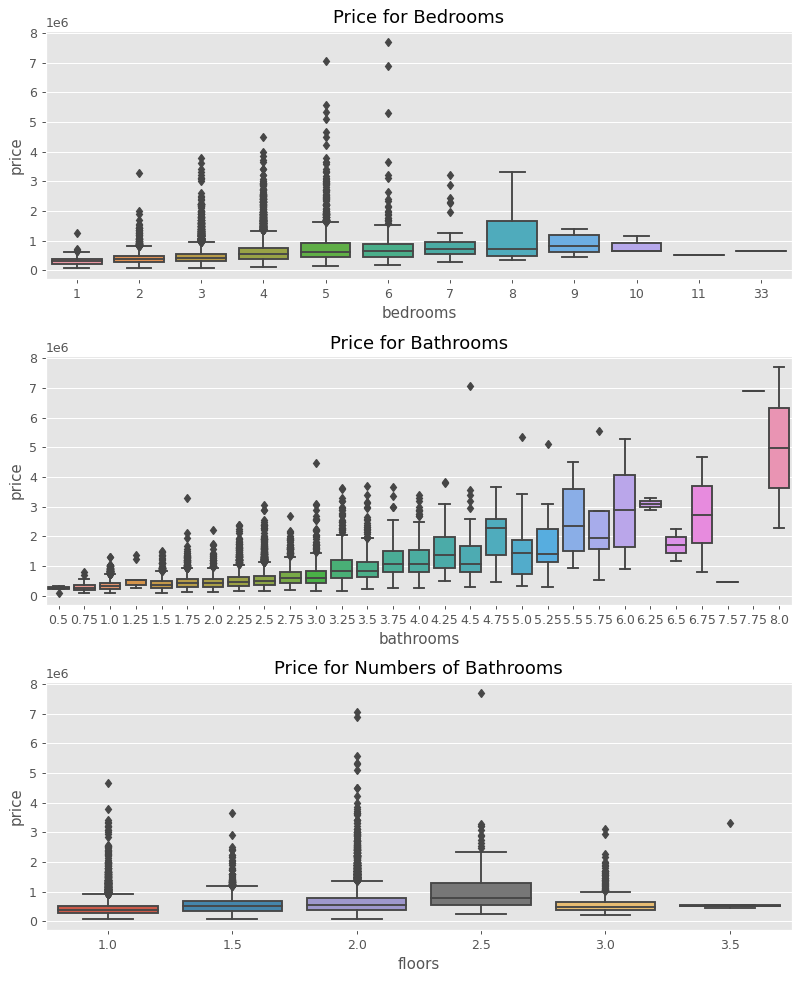

In [523]:
# Canvas
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (9, 11), dpi = 90, tight_layout = True)

#ax1
sns.boxplot(x = 'bedrooms', y = 'price', data = df_plot, ax = ax1)
ax1.set_title("Price for Bedrooms")

#ax2
sns.boxplot(x = 'bathrooms', y = 'price', data = df_plot, ax = ax2)
ax2.set_title("Price for Bathrooms")

#ax3
sns.boxplot(x = 'floors', y = 'price', data = df_plot, ax = ax3)
ax3.set_title("Price for Numbers of Bathrooms")

plt.show()

En el caso de las habitaciones, se puede ver claramente que existe una alta dispersión en el precio en aquellos inmuebles entre 3 y 7 habitaciones. Sin embargo, la media se encuentra cerca entre ellas.

En el caso de los baños si vemos una media creciente conforme aumenta el número de los mismos, por tanto si parece haber una relación entre ellos. Curiosamente no podemos decir lo mismo en el número de las plantas disponibles en la vivienda.

#### Variables vs Variables

Ya estudiamos cómo se comportan las variables con el precio objetivo (Variables independientes con Variable Dependiente). Sin embargo, antes de finalizar este examen gráfico-estadístico, es necesario saber ¿Qué hay de las correlaciones entre nuestras variables dependientes?

Este apartado es fundamental, ya que si existe una correlación entre las variables pude ocurrir un sobre ajuste en el modelo **overfiting**. Para determinar esto, es necesario visualizar gráficamente aquellas variables que intuitivamente podemos creer que existe cierta correlación y, seguido, realizar un examen numérico estadístico para evidenciar si realmente existe dicha correlación o no.

Existen varías variables que determinan los pies cuadrados de vivienda por zona, como `above` y `basement`, adicionalmente de sus versiones en 2015 de `living` y `lot`. Posiblemente una combinanción lineal entre Living y Lot pueda generar un mayor cociente entre bathrooms/betrooms, a mayor área habitable, es natural intuir que el número de habitaciones y baños disponibles en la vivienda sea mayor. Realicemos un plot para ver si esto es cierto.

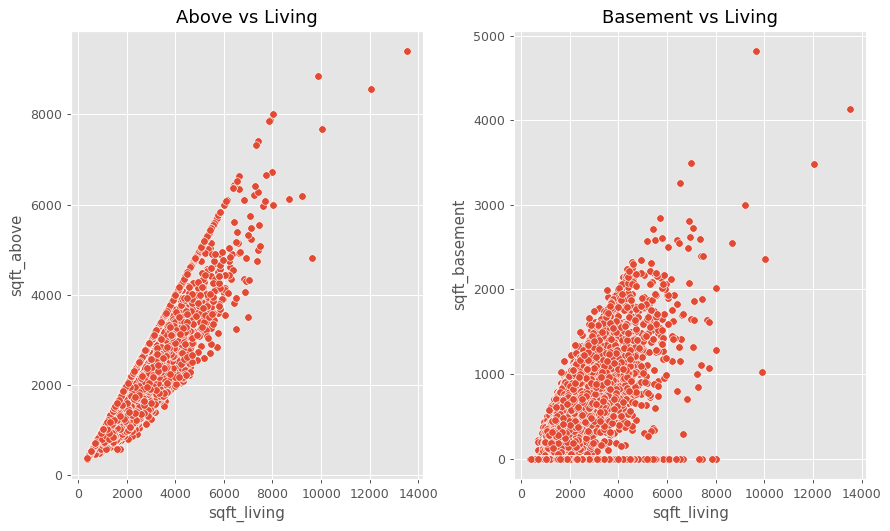

In [524]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 6), dpi = 90, tight_layout = True)

sns.scatterplot(data = df_plot, x = 'sqft_living', y = 'sqft_above', ax = ax1)
ax1.set_title('Above vs Living')
sns.scatterplot(data = df_plot, x = 'sqft_living', y = 'sqft_basement',  palette = 'Paired', ax = ax2)
ax2.set_title('Basement vs Living')

plt.show()

Vemos una clara correlación entre above y basement con living. Puede ser recomendable eliminar estas variable.

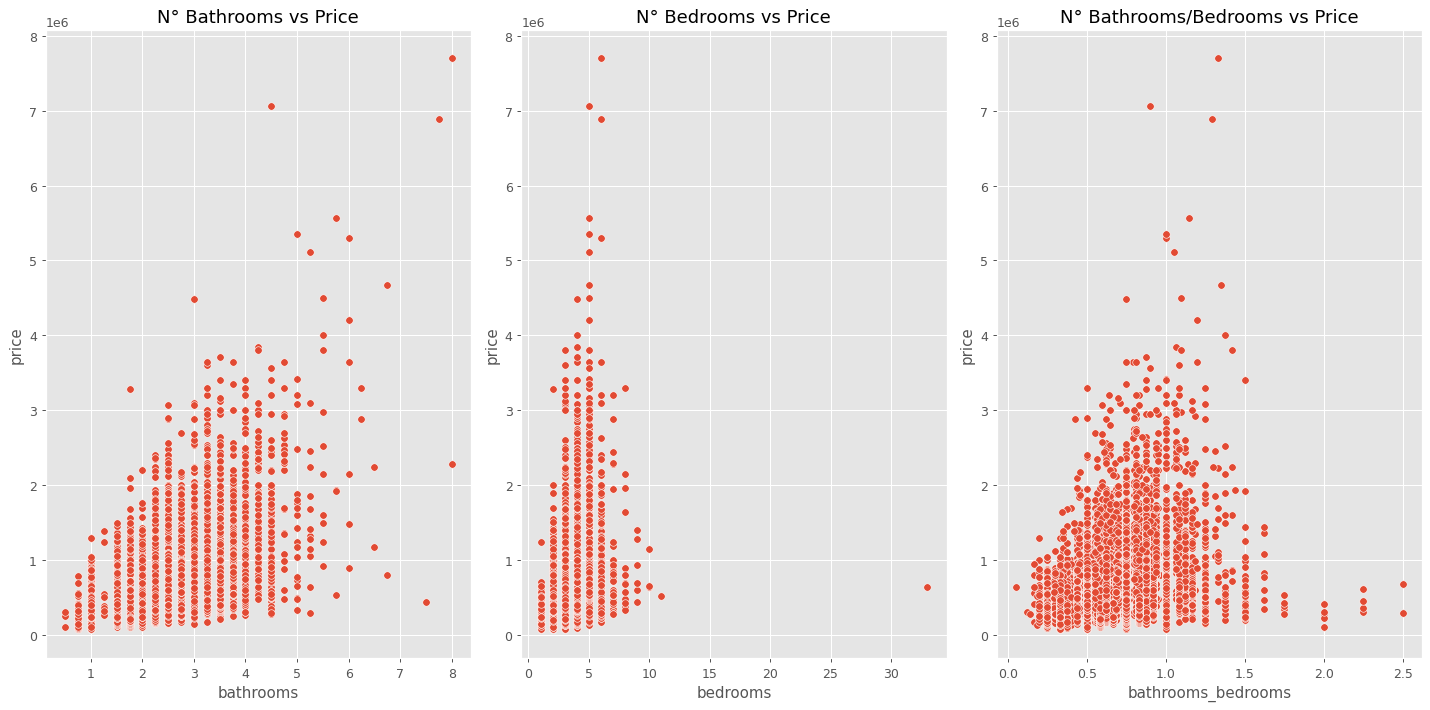

In [525]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 8), dpi = 90, tight_layout = True)

sns.scatterplot(data = df_plot, x = 'bathrooms', y = 'price', ax = ax1)
ax1.set_title('N° Bathrooms vs Price')
sns.scatterplot(data = df_plot, x = 'bedrooms', y = 'price', ax = ax2)
ax2.set_title('N° Bedrooms vs Price')

df_plot['bathrooms_bedrooms'] = df_plot['bathrooms']/df_plot['bedrooms']
sns.scatterplot(data = df_plot, x = 'bathrooms_bedrooms', y = 'price', ax = ax3)
ax3.set_title('N° Bathrooms/Bedrooms vs Price')

plt.show()

Parece haber cierta correlación entre el número de baños con respecto. realizando un cociente entre ambos elementos no vemos dicho correlació. De igual forma es necesario realizar un estudio numérico con una matriz de correlación de "Pearson" para determinar si es una correlación fuerte o suficiente como para influir en el modelo.

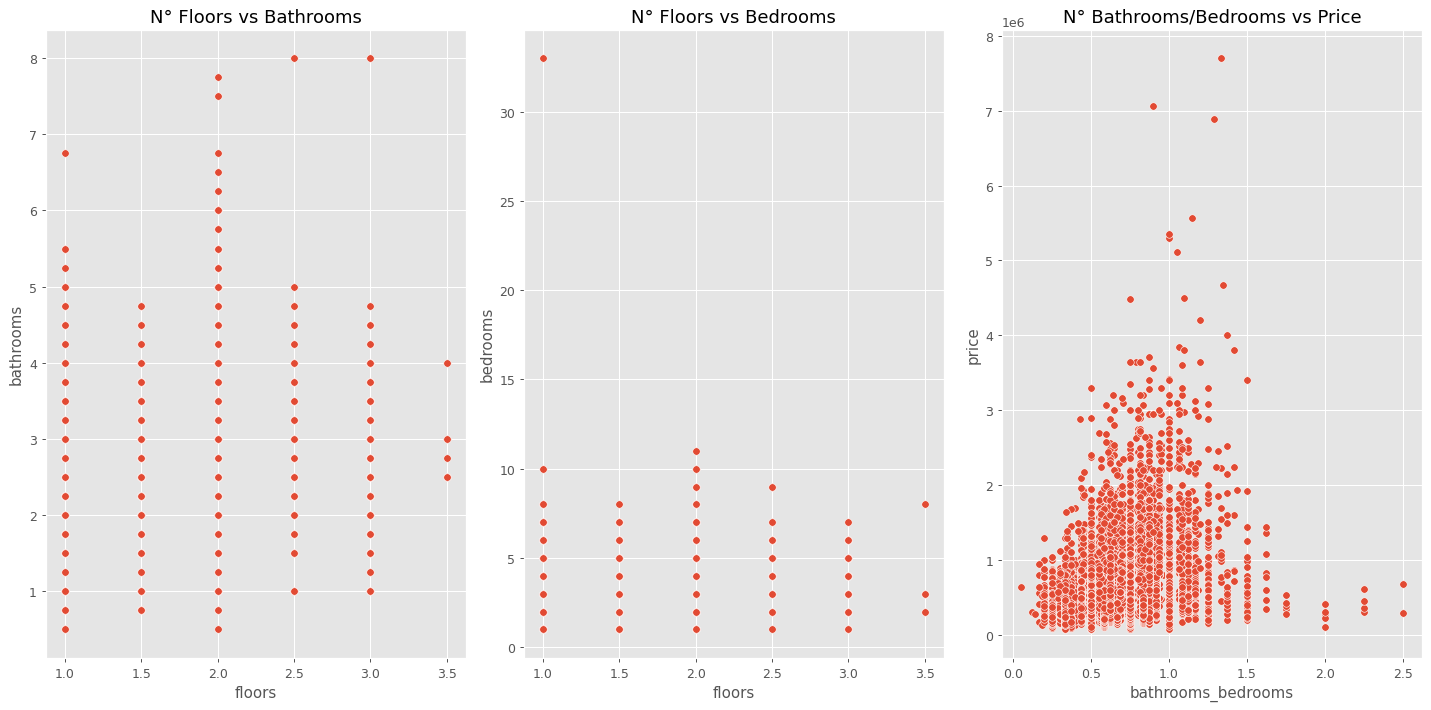

In [526]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 8), dpi = 90, tight_layout = True)

sns.scatterplot(data = df_plot, x = 'floors', y = 'bathrooms', ax = ax1)
ax1.set_title('N° Floors vs Bathrooms')
sns.scatterplot(data = df_plot, x = 'floors', y = 'bedrooms', ax = ax2)
ax2.set_title('N° Floors vs Bedrooms')

df_plot['bathrooms_bedrooms'] = df_plot['bathrooms']/df_plot['bedrooms']
sns.scatterplot(data = df_plot, x = 'bathrooms_bedrooms', y = 'price', ax = ax3)
ax3.set_title('N° Bathrooms/Bedrooms vs Price')

plt.show()

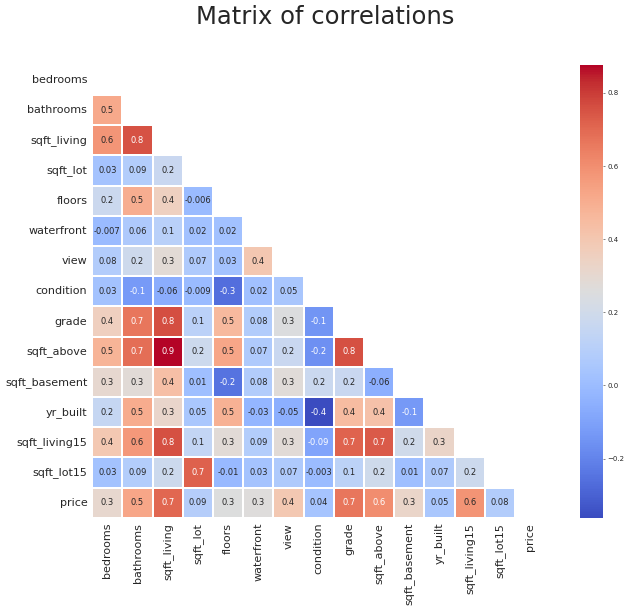

In [527]:
# correlation matrix with the Pearson method 
corr = data.drop(['id', 'date', 'yr_renovated', 'zipcode', 'lat', 'long','city'], axis = 1).corr(method='pearson')
# sns.pairplot(corr)

# We Plot a Heatmap to see this level correlation intuitively
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (18, 12), dpi = 50)
    fig.suptitle('Matrix of correlations', fontsize = 35)
    ax = sns.heatmap(corr, linewidths=0.1, annot = True,
                     annot_kws= {'size' :12}, fmt = '.1g', square = True, 
                     mask = mask, cmap = "coolwarm")
    ax.tick_params(axis = 'both', labelsize = 16)

Existen altas correlaciones de `sqft_living` con su versión de 2015 y las variables de `grade`, `sqft_above` y `bathrooms` con valores superiores a 0,7. Podemos interpretar una alta correlación entre estas variables independientes. Es necesario quedarse con aquellas que contengan mayor información sobre el target.

El caso de las `bathrooms` es mas intuitivo. Cuando aumenta el área disponible es natural pensar en un aumento del número de habitaciones y baños disponibles, aunque en este caso `bedrooms` parece tener una incidencia menor.

Con el grado de calificación puede ser esperable. Se trata de una calificación sobre la calidad de vivienda y puede ser esperable que en un aumento en el área acarré un mejor grado de calificación.

Se considera necesario realizar un proceso iterativo entre las features observadas y finalmente seleccionar una configuración que sopese una menor cantidad de sobre ajuste en el modelo.

### 2.1 Preprocesamiento

Existen variables que no entregan valor a un modelamiento o estudio estadístico. `['date', 'zipcode']` carecen de interes y pueden ser eliminadas para el modelado pero pueden ser interesantes para una visualización de los datos.

Existen campos referentes a la cantidad de pies cuadrados del living y el total tanto antes de su remodelación como la medida de referencia para el año 2015. Puede ser conveniente identificar con una variable Booleana identificando si existe una ampliación o no de estos espacios.

Adicionalmente hay varias medidas en pies cuadrados. Las mas significativas son los tamaños del Living y el lot. Los pies cuadrados de la base y el piso superior pueden ser descartados para el modelo, sin embargo como vimos en el apartado anterior, la influencia de above y basemente es considerable sobre otras variables contempladas.

Podemos eliminar la longitud y latitud del set de datos.

In [528]:
# Copy data in new dataframe
df = data.copy()

#### Data Binning

El Binning nos facilitará un suavizamiento de los datos con el objetivo de minimizar los pequeños errores de observación y reduce las posibilidades de sobre ajuste del modelo. En este caso realizaremos esta técnica en los campos de `yr_built` y `yr_renovated`.

In [529]:
# Copy data in new dataframe
df = data.copy()

def get_age(year_sale, year_data):
    if year_data == 0:
        return 0
    else:
        if year_sale < year_data:
            return 0
        else:
            return year_sale - year_data

df['year'] = df['date'].apply(lambda x: int(x.split('/')[2]))

df['age'] = df.apply(lambda x: get_age(x.year, x.yr_built), axis = 1)
df['renovated_age'] = df.apply(lambda x: get_age(x.year, x.yr_renovated), axis = 1)

df['age_bins'] = pd.qcut(df['age'], q = 7, duplicates = 'drop')
df['renovated_bins'] = pd.cut(df['renovated_age'], bins = 5)

df['age_bins'] = df['age_bins'].astype(str)
df['renovated_bins'] = df['renovated_bins'].astype(str)

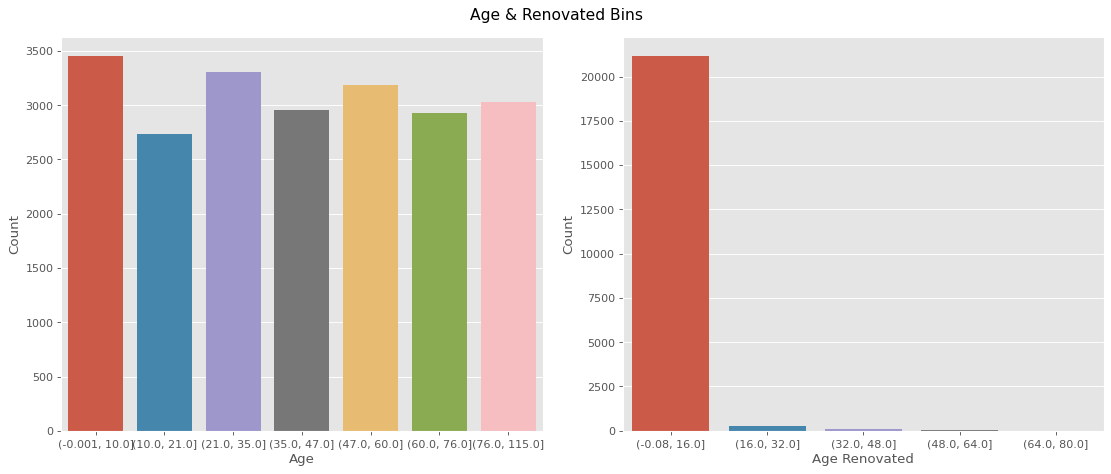

In [530]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6), dpi = 80, tight_layout = True)

#df.groupby(['age_bins'])['age_bins'].count()

sns.barplot(y = df.groupby(['age_bins'])['age_bins'].count(), 
            x = df.groupby(['age_bins'])['age_bins'].count().index, ax  = ax1)

ax1.set_xlabel("Age")
ax1.set_ylabel("Count")

sns.barplot(y = df.groupby(['renovated_bins'])['renovated_bins'].count(), 
            x = df.groupby(['renovated_bins'])['renovated_bins'].count().index, ax  = ax2)

ax2.set_xlabel("Age Renovated")
ax2.set_ylabel("Count")

fig.suptitle("Age & Renovated Bins", fontsize = 14)

plt.show()

En el caso de año de construcción, hemos podmeos balancear la data y reducimos el sobre ajuste. En el caso de la edad de renovación, debido al alto sesgo, es inevitable que la mayor parte de los datos estarán concentrado en la primera sección de (0, 16] años.

Realizamos una sustitución para que dichos rangos estén definidos en grados de (0, 7) y (0, 4) para la edad de construcción y la edad de renovación respectivamente. Esto permitirá al modelo realizar una interpretación escalar de esta variable.

In [531]:
# Replace Values
df['age_bins'].replace({'(-0.001, 10.0]': '(0, 10.0]'})
df['renovated_bins'].replace({'(-0.08, 16.0]': '(0, 16.0]'})

age_bins = df['age_bins'].value_counts().sort_index().index.to_list()
renovated_bins = df['renovated_bins'].value_counts().sort_index().index.to_list()

age_dict = dict(zip(age_bins, range(0, 7)))
renovated_dict = dict(zip(renovated_bins, range(0, 5)))

df['age_bins'] = df['age_bins'].replace(age_dict)
df['renovated_bins'] = df['renovated_bins'].replace(renovated_dict)

In [532]:
df.iloc[580].to_dict()

{'id': 7853240200,
 'date': '16/5/2014',
 'bedrooms': 3,
 'bathrooms': 2.5,
 'sqft_living': 2720,
 'sqft_lot': 6439,
 'floors': 2.0,
 'waterfront': 0,
 'view': 0,
 'condition': 3,
 'grade': 9,
 'sqft_above': 2720,
 'sqft_basement': 0,
 'yr_built': 2005,
 'yr_renovated': 0,
 'zipcode': 98065,
 'lat': 47.5422,
 'long': -121.86,
 'sqft_living15': 3180,
 'sqft_lot15': 7320,
 'price': 619000,
 'city': 'Snoqualmie',
 'county': 'King County',
 'year': 2014,
 'age': 9,
 'renovated_age': 0,
 'age_bins': 0,
 'renovated_bins': 0}

#### Feature Engineering

Probemos eliminando las columnas de living, above y basement. Quedandonos con las versiones actualizadas de 2015 y nuevos campos que identifiquen la tasa de aumento entre el area original y el área registrada en 2015 para el living y el lot.

Aprovechamos y eliminamos las columnas que no nos interesa en el modelado y definimos el ID como indice del dataframe.

Realizamos las modificaciones en un nuevo dataframe, copia de la original.

In [533]:
columns = ['date', 'year', 'zipcode', 'yr_built', 
              'yr_renovated', 'age', 'renovated_age']


df.drop(columns, axis = 1, inplace = True)
df.set_index('id', inplace = True)
df.head()


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,price,city,county,age_bins,renovated_bins
id,,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,47.5112,-122.257,1340,5650,221900,King County,Washington,4,0
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,47.7210,-122.319,1690,7639,538000,Seattle,King County,5,1
5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,0,47.7379,-122.233,2720,8062,180000,Kenmore,King County,6,0
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,47.5208,-122.393,1360,5000,604000,Seattle,King County,4,0
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,47.6168,-122.045,1800,7503,510000,Sammamish,King County,2,0


Normalización de la Variable Objetivo

Revisamos como está el estado de la variable objetivo para determinar cómo se encuentra distribuida y su función de probabilidad. Finalmente, realizamos un ajuste a la misma a una distribución parecida a la normal o bimodal dependiendo del caso.

En primer lugar echemos un vistazo de como se encuentra:

The Parameters mu = 540216.02 and sigma = 367177.34


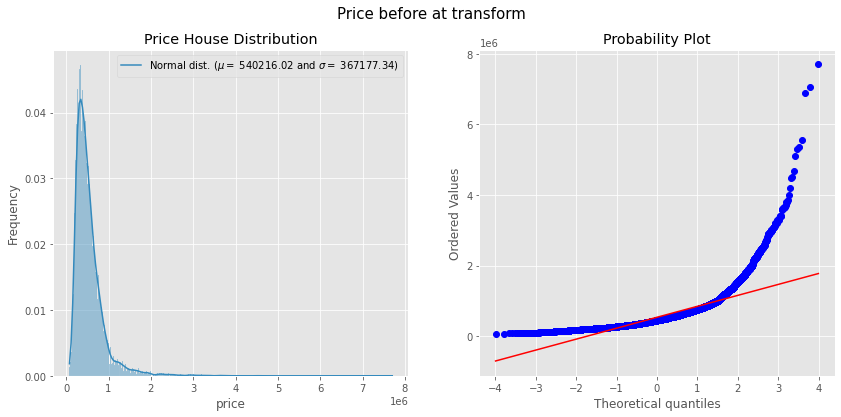

In [534]:
# built canvas
fig, (ax1, ax2) = plt.subplots(figsize = (14, 6), nrows  = 1, ncols = 2)
    
sns.histplot(data['price'], hue_norm = norm, stat = 'frequency', kde = True, ax = ax1)
ax1.set_title("Price House Distribution")

# Calculate paramenters for normal distribution mu and sigma
(mu, sigma) = norm.fit(data['price'])
print("The Parameters mu = {:.2f} and sigma = {:.2f}".format(mu, sigma))

ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
           loc = 'best')

ax1.set_label('Frecuency')

# Get also a the probability plot in price column (variable target)
ax2 = stats.probplot(data['price'], plot = plt)

# Set title
fig.suptitle("Price before at transform", fontsize = 15)

plt.show()

Podemos encontrar un claro sesgo hacia la izquierda, una larga cola hacia la derecha. Por tanto, la media se encuentra mucho mas a la izquierda que la mediana. Vemos la curva de probabilidad y podemos determinar una falta de lineraridad en sus quantiles teóricos. Sin lugar a duda es necesario realizar el ajuste.

In [535]:
# # Normalize of target variable with Log(1 + x)
df['price'] = df['price'].apply(lambda x: np.log1p(x))

The Parameters mu = 13.05 and sigma = 0.53


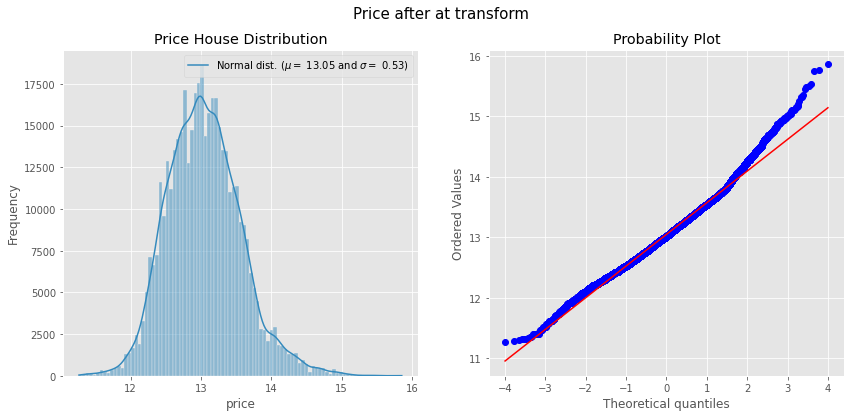

In [536]:
#built canvas
fig, (ax1, ax2) = plt.subplots(figsize = (14, 6), nrows  = 1, ncols = 2)
    
sns.histplot(df['price'], hue_norm = norm, stat = 'frequency', kde = True, ax = ax1)
ax1.set_title("Price House Distribution")

# Calculate paramenters for normal distribution mu and sigma
(mu, sigma) = norm.fit(df['price'])
print("The Parameters mu = {:.2f} and sigma = {:.2f}".format(mu, sigma))

ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
           loc = 'best')

ax1.set_label('Frecuency')

# Get also a the probability plot in price column (variable target)
ax2 = stats.probplot(df['price'], plot = plt)

# Set title
fig.suptitle("Price after at transform", fontsize = 15)

plt.show()

Podemos obervar que con una transformación logarítmica (1 + x) se ha podido ajustar la curva a algo mucho mas parecido a la normal. $\sigma$ es bastante mas pequeño y la curva de probabilidad se muestra un comportamiento mas lineal.

#### Dummy Variables

Es natural mensar que un modelo de regresión lineal no está preparado para interpretar la columna `city` como valores númericos o de graduación. Una buena técnica es realizar realizar una transformación y generar unos dummies variables donde fija 1 para la existencia del mismo y 0 para su no existencia.

En el caso de la columna `city` resulta incoveniente realizar este proceso para las 26 ciudades registradas en el estado de Washington. Probemos inicialmente realizar el dummy variables en counties o condados dentro del estado de Washington.

In [537]:
print('N° counties in DataFrame: {}'.format(len(df['county'].unique())))

N° counties in DataFrame: 2


Obtenemos los dummy variables de county

In [538]:
# Get Dummy
df.drop(['city'], axis = 1, inplace = True)
df = pd.get_dummies(df, prefix_sep = '_')
df.drop(['county_King County'], axis = 1, inplace = True)
df.sample(5)

# Save clean Data before transformation
df.to_csv('../data/clean_data.csv')

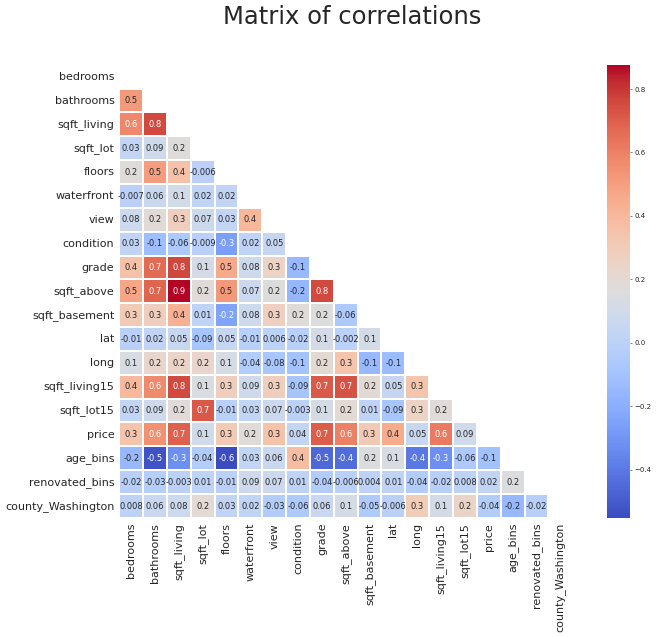

In [539]:
corr = df.corr()

# We Plot a Heatmap to see this level correlation intuitively
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (18, 12), dpi = 50)
    fig.suptitle('Matrix of correlations', fontsize = 35)
    ax = sns.heatmap(corr, linewidths=0.1, annot = True,
                     annot_kws= {'size' :12}, fmt = '.1g', square = True, 
                     mask = mask, cmap = "coolwarm")
    ax.tick_params(axis = 'both', labelsize = 16)

#### Escalado

Los algorítmos están optimizados para trabajar con una escala común entre las features. Es recomendable realziar un escalamiento de todos los valores en las variables independientes. Esto es necesario si queremos que el modelo esté correctamente ajustado. Realizamos un escalamiento Min Max, el cual deja los valores entre 0 y 1, esto nos asegura un escalamiento bajo la misma escala para todas las features. 

La libería Scikit-Learn nos ofrece a través del modulo `preprocessing` la clase `PowerTransform()`, podemos hacer pasar el parámetro `method='yeo-johnson'` con el cual accederemos a la transformación de *Yeo-Johnson*. La clase ya está construida y contempla una seleccion óptima de *lambdas* para la transformación de cada feature. 

Es conveniente guardar la instancia de la clase `PowerTransform()` para acceder al mismo y poder transformar la data y regresar los valos datos a su escala original. Esto será muy util para acceder a los escaladores desde una app externa. 

`MinMaxScaler()`

In [540]:
def minMax_scaler(train_set, name = 'scaler.pkl'):

    if (os.path.isdir('../scalers/')):


        if (os.path.isfile('../scalers/' + name)):

            minMax = joblib.load('../scalers/' + name)
            df_scaler = minMax.transform(train_set)

            # We built again the DataFrame with its columns and indexes
            df_columns = train_set.columns
            df_index = train_set.index.values
            df_scaler = pd.DataFrame(df_scaler, columns=df_columns, index = df_index)

            # Remove Variables
            del df_columns, df_index

            return df_scaler

        else:
            
            """    Yeo-Johnson Scaler for DataFrame    """

            # Instance
            minMax = MinMaxScaler().fit(train_set)

            # Scaler MinMax Scaler method
            df_scaler = minMax.transform(train_set)

            # We built again the DataFrame with its columns and indexes
            df_columns = train_set.columns
            df_index = train_set.index.values
            df_scaler = pd.DataFrame(df_scaler, columns=df_columns, index = df_index)

            # Remove Variables
            del df_columns, df_index

            joblib.dump(minMax, '../scalers/' + name)

            return df_scaler


    else:
        os.mkdir('scalers')

        # Instance
        minMax = MinMaxScaler().fit(train_set)

        # Scaler MinMax Scaler method
        df_scaler = minMax.transform(train_set)

        # We built again the DataFrame with its columns and indexes
        df_columns = train_set.columns
        df_index = train_set.index.values
        df_scaler = pd.DataFrame(df_scaler, columns=df_columns, index = df_index)

        # Remove Variables
        del df_columns, df_index

        joblib.dump(minMax, '../scalers/' + name)

        return df_scaler

`PowerTransform(method = 'yeo-johnson')`

In [541]:
def yjohnson_scaler(train_set, name = 'scaler.pkl'):

    if (os.path.isdir('../scalers/')):


        if (os.path.isfile('../scalers/' + name)):

            pt = joblib.load('../scalers/' + name)
            df_scaler = pt.transform(train_set)

            # We built again the DataFrame with its columns and indexes
            df_columns = train_set.columns
            df_index = train_set.index.values
            df_scaler = pd.DataFrame(df_scaler, columns=df_columns, index = df_index)

            # Remove Variables
            del df_columns, df_index

            return df_scaler

        else:
            
            """    Yeo-Johnson Scaler for DataFrame    """

            # Instance
            pt = PowerTransformer(method='yeo-johnson').fit(train_set)

            # Scaler yeo-johnson method
            df_scaler = pt.transform(train_set)

            # We built again the DataFrame with its columns and indexes
            df_columns = train_set.columns
            df_index = train_set.index.values
            df_scaler = pd.DataFrame(df_scaler, columns=df_columns, index = df_index)

            # Remove Variables
            del df_columns, df_index

            joblib.dump(pt, '../scalers/' + name)

            return df_scaler


    else:
        os.mkdir('scalers')

        # Instance
        pt = PowerTransformer(method='yeo-johnson').fit(train_set)

        # Scaler yeo-johnson method
        df_scaler = pt.transform(train_set)

        # We built again the DataFrame with its columns and indexes
        df_columns = train_set.columns
        df_index = train_set.index.values
        df_scaler = pd.DataFrame(df_scaler, columns=df_columns, index = df_index)

        # Remove Variables
        del df_columns, df_index

        joblib.dump(pt, '../scalers/' + name)

        return df_scaler

    pass

Separamos el dataframe entre las variables independientes y las variable dependiente ya que Price ya se encuentra normalizada en apartados anteriores. Hay que recordar que los objetos *Python* están guardados con la extención *pkl*.

In [542]:
# We separate between train features and target variable
X = df.drop(['price', 'county_Washington'], axis = 1)
y = df['price']

# Call function create_scaler
#X = yjohnson_scaler(X, 'yeo-johnson.pkl')
X = minMax_scaler(X, 'min_max.pkl')

# See Train Data Scaled
X.sample(5)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,age_bins,renovated_bins
7300000650,0.09375,0.266667,0.135616,0.002596,0.4,0.0,0.00,0.50,0.5,0.186572,0.000000,0.440405,0.273256,0.226295,0.002996,0.000000,0.0
3336000230,0.03125,0.066667,0.056507,0.003320,0.0,0.0,0.00,0.25,0.4,0.054181,0.041494,0.600290,0.208472,0.235932,0.004996,0.833333,0.0
4078300024,0.09375,0.300000,0.153253,0.002232,0.0,0.0,0.75,0.50,0.4,0.083628,0.224066,0.888210,0.201827,0.352951,0.006160,0.500000,0.0
2878600200,0.06250,0.066667,0.111301,0.002156,0.0,0.0,0.00,0.50,0.4,0.094229,0.103734,0.858935,0.164452,0.199793,0.003939,0.500000,0.0
6414600262,0.03125,0.066667,0.053082,0.004682,0.0,0.0,0.00,0.50,0.4,0.073027,0.000000,0.915715,0.156146,0.117192,0.008635,0.666667,0.0


In [543]:
# See Target Variable Scaled
y.sample(5)

id
6662400105    12.834684
3793500160    12.685411
1954700615    13.623140
8074200185    12.821261
3876200060    12.854487
Name: price, dtype: float64

In [544]:
df = pd.concat([X, y], axis = 1)
df.sample(2)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,age_bins,renovated_bins,price
8082400076,0.09375,0.233333,0.172089,0.002639,0.4,0.0,0.0,0.75,0.6,0.220259,0.029046,0.846550,0.098837,0.237653,0.004489,0.833333,0.0,13.681980
9528101214,0.06250,0.400000,0.096233,0.000449,0.8,0.0,0.0,0.50,0.5,0.132391,0.000000,0.847193,0.161960,0.188436,0.000704,0.000000,0.0,13.384729


## 3 Modelado

Teniendo toda la data preparada, limpia, transformada y haber construido a su vez un par de variables extras que pueden ser interesantes en el modelado, es hora de empezar a construir el modelo, realizar su entrenamiento y realizar testing.

Se trata de un problema de regresión, ya que la variable objetivo es una variable continua. Existe múltimples algorítmos de regresión que podemos utilizar, unos mas complejos y otros mucho mas simple como una ecucación lineal multivariable. Conforme el proyecto va avanzando, vamos construyendo más modelos de regresión que puedan ser interesantes probar y evualuar su nivel de score general, que modelo se acerca mas al comportamiento de los datos y ofrece una predicción mas adecuada cuidando el *overfiting* y minimizando el error cuadrático medio en la data de testing.

Existen un último paso a realizar antes de empezar a entrenar nuestro(s) modelo(s). Hay que subdividir la data de entrenamiento y la data de testing. Es recomendable obtener una data de entrenamiento en un rango desde (60 → 80)%, podemos gráficar una curva de error medio que nos permita saber en que punto encontramos un entrenamiento óptimo para el modelo.

Extraemos la data de entrenamiento y la data de testing a través de la función `train_test_split()` de *sklearn.model_selection* que nos permite elegir de forma pseudoaleatoria los datos para ambos conjuntos.

Transformamos la data en arreglos de *Numpy*.

In [545]:
# Arrays of Numpy
X = np.array(X)
y = np.array(y)

# Copy DataFrame
df_final = df.copy()

Realizamos una selección de un set de entrenamiento y otro de testing.

In [546]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=2022)

### 3.1 Linear Regression

Partimos de un algorítmo básico. Anteriormente ya mostramos como funciona la regresión lineal, en ese caso fue una relación lineal de una variable independiente y una variable dependiente o objetivo. Ya en este caso, la regresión de múltiple con $n$ número de variables en el data set para una variable objetivo como output.

Definición escalar de la ecuación:

$
f(x_{1},...,x_{j}) = \beta_{0} + \beta_{1}x_{1} + ... + \beta_{j}x_{j} 
$

Creamos la instacia del modelo y realizamos el entrenamiento. Podemos ver el nivel de correlación $R^2$ tanto para los conjuntos de testing y entrenamiento.

In [547]:
# instance
lr = LinearRegression(fit_intercept = True)

# Traning with X_train and y_train
lr.fit(X_train, y_train)

# Scores in training and test
print("Determination R2: ")
print("Train: ",lr.score(X_train, y_train))
print("Test: ",lr.score(X_test, y_test))

Determination R2: 
Train:  0.772328680207307
Test:  0.7586741044508373


Podemos ver que parece no haber overfiting, el coeficiente de determinación $R^2$. Sin embargo, se nota una falta de ajuste y podemos asumir que el nivel de error cuadrático medio será alto.

Juntemos los valores en el DataFrame original y visualizamos el comportamiento del modelo

In [548]:
# Paste Y Predict.
# Transform inverse of target variable 
df_final['price'], df_final['lregression_pred'] = np.expm1(df_final['price']), np.expm1(lr.predict(X))

df_final.sample(5)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,age_bins,renovated_bins,price,lregression_pred
952004745,0.09375,0.066667,0.059932,0.003168,0.0,0.0,0.0,0.50,0.3,0.058893,0.041494,0.656426,0.116279,0.149888,0.005857,1.000000,0.0,400800.0,283114.135019
6852700477,0.03125,0.133333,0.079623,0.001484,0.0,0.0,0.0,0.50,0.4,0.073027,0.064315,0.751810,0.166113,0.223886,0.002698,1.000000,0.0,550000.0,407666.925509
2953000300,0.06250,0.066667,0.052226,0.005550,0.0,0.0,0.0,0.50,0.4,0.071849,0.000000,0.414509,0.259136,0.203235,0.010374,0.500000,0.0,201000.0,239464.047694
3629980860,0.09375,0.300000,0.167808,0.002060,0.4,0.0,0.0,0.50,0.6,0.230860,0.000000,0.637928,0.439369,0.346068,0.003919,0.000000,0.0,680000.0,539203.423095
1561600025,0.06250,0.133333,0.110445,0.005014,0.0,0.0,0.0,0.75,0.4,0.151943,0.000000,0.696960,0.263289,0.335743,0.010800,0.666667,0.0,712500.0,417751.106970


Podemos realizar una destransformación de las varibales incluidas las variables objetivos. Utilizamos dos indicadores, el R2 de correlación entre el conjunto predecido y el precio real y a su vez, la raiz de error cuadrático medio, se tratan de dos indicadores base para determinar el nivel de efectividad del modelo.

In [549]:
# Get RMSE & R2
rmse_lr = np.sqrt(metrics.mean_squared_error(df_final['price'], df_final['lregression_pred'], squared=True))
r2_lr = metrics.r2_score(df_final['price'], df_final['lregression_pred'])

print("Determination coef R2: {}".format(r2_lr))
print("RMSE Root Median Squared Error: {}".format(rmse_lr))

error_models = pd.DataFrame([rmse_lr, r2_lr], columns = ['linear_regression'], index = ['rmse', 'r2'])

Determination coef R2: 0.7119416909924992
RMSE Root Median Squared Error: 197067.98444780035


### 3.2 Random Forest Regression

Se trata de un algorítmo supervisado. El mismo crea un un bosque de árboles para la regressión. Generalmente cuanto mayor cantidad de árboles más robusto es el modelo y con mayor presición proveerá. El resultado de cada uno de estos arboles se promedian y se obtiene la predicción del problema. Este método tiene como desventaja (en el caso de utilizarse para la regresión continua), es que sus resultados están sujetos al rango del último nodo de estos árboles y suele sobreajustar los conjuntos de datos que son particularmente ruidosos.

Utilizamos el error cuadrático medio como criterio de soporte o ajuste, se creará con 4000 árboles y una máxima profundiad de 4 nodos.

In [550]:
forest = RandomForestRegressor(n_jobs = multiprocessing.cpu_count() - 1,
                                oob_score = True, n_estimators = 4000,
                                criterion = 'squared_error', # -> Mean Squared Error as Support Criteria
                                max_depth = 6,
                                min_samples_split  = 4,
                                min_samples_leaf = 2,
                                max_features = 1.0) 

# Train Model
forest.fit(X_train, y_train)

# Score in training and test
print("Determination R2: ")
print("Train: ", forest.score(X_train, y_train))
print("Test: ", forest.score(X_test, y_test))

Determination R2: 
Train:  0.8555058307912107
Test:  0.8272679257167994


En comparación con la regresión lineal parece tener mejor nivel de $R^{2}$.

In [551]:
df_final['rforest_pred'] = np.expm1(forest.predict(X))

r2_rf = metrics.r2_score(df_final['price'], df_final['rforest_pred'])
rmse_rf = np.sqrt(metrics.mean_squared_error(df_final['price'], df_final['rforest_pred'], squared=True))

print("Determination coef R2: {}".format(r2_rf))
print("RMSE Root Median Squared Error: {}".format(rmse_rf))

error_models['random_forest'] = [rmse_rf, r2_rf]

Determination coef R2: 0.8069304462768525
RMSE Root Median Squared Error: 161336.55069459078


Vemos el error global y lo añadimos al dataframe de los modelos.

In [552]:
error_models

,linear_regression,random_forest
rmse,197067.984448,161336.550695
r2,0.711942,0.806930


Estás son las características mas influyentes en el modelo.

In [553]:
forest_feats = pd.DataFrame(forest.feature_importances_,
                            index = df.columns[:-1].to_list(),
                            columns = ['features_importance'])

forest_feats.sort_values(['features_importance'], ascending = False)

,features_importance
sqft_living,0.350079
lat,0.337601
grade,0.250800
long,0.020831
sqft_living15,0.012800
view,0.007893
sqft_lot15,0.004902
sqft_above,0.004308
age_bins,0.003988
sqft_lot,0.003731


### 3.3 Lasso Regression

Al igual que la regresión lineal simple, este modelo funciona de forma muy similar en un modelo lineal. Lasso regression permite a su vez penalizar las características para generar mayor o menos peso. Esto permite penalizar aquellas variables que aportan poca información en el modelo, por tanto reduce el nivel de ruido.

In [554]:
kf = RepeatedKFold(n_splits = 10, random_state = 2022, n_repeats = 10 )

lasso = LassoCV(n_jobs = multiprocessing.cpu_count() - 1,
                cv = kf,
                random_state = 2022)

lasso.fit(X, y)

# Score in training and test
print("Determination R2: ")
print("Train: ", lasso.score(X_train, y_train))
print("Test: ", lasso.score(X_test, y_test))

Determination R2: 
Train:  0.771817544407333
Test:  0.759643506383455


In [555]:
df_final['lasso_pred'] = np.expm1(lasso.predict(X))

r2_ls = metrics.r2_score(df_final['price'], df_final['lasso_pred'])
rmse_ls = np.sqrt(metrics.mean_squared_error(df_final['price'], df_final['lasso_pred'], squared=True))

print("Determination coef R2: {}".format(r2_ls))
print("RMSE Root Median Squared Error: {}".format(rmse_ls))

error_models['lasso_pred'] = [rmse_ls, r2_ls]

Determination coef R2: 0.7230308172164867
RMSE Root Median Squared Error: 193237.5827287701


In [556]:
error_models

,linear_regression,random_forest,lasso_pred
rmse,197067.984448,161336.550695,193237.582729
r2,0.711942,0.806930,0.723031


Este modelo presenta una ligera mejora con respecto al modelo clásico de regresión lineal múltiple.

In [557]:
df_final.sample()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,age_bins,renovated_bins,price,lregression_pred,rforest_pred,lasso_pred
2883200875,0.03125,0.133333,0.13613,0.00332,0.0,0.0,0.0,0.5,0.5,0.09894,...,0.850893,0.154485,0.285837,0.006144,0.833333,0.0,680200.0,572924.44941,660067.106874,571167.75602


### Guardado de Modelos

Guardamos los modelos en la carpeta `models/` con el objetivo de acceder a el cuando sea necesario.

In [558]:
joblib.dump(lr, '../models/' + 'linearRegression.pkl')
joblib.dump(forest, '../models/' + 'randomForest.pkl')
joblib.dump(lasso, '../models/' + 'lassoRegression.pkl')

['../models/lassoRegression.pkl']